In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
df = pd.read_csv("/content/train_FD001.txt.zip", sep=" ", header=None)
# Drop empty columns at the end
df.dropna(axis=1, inplace=True)

# Add column names
df.columns = ["unit", "time"] + [f"op_setting_{i}" for i in range(1, 4)] + [f"sensor_{i}" for i in range(1, 22)]
df.head()


,unit,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


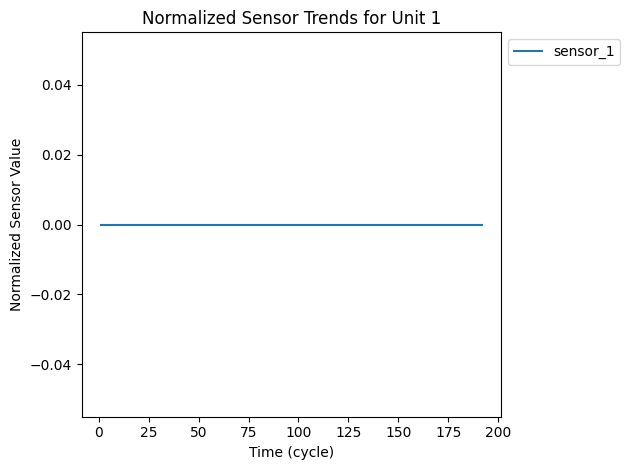

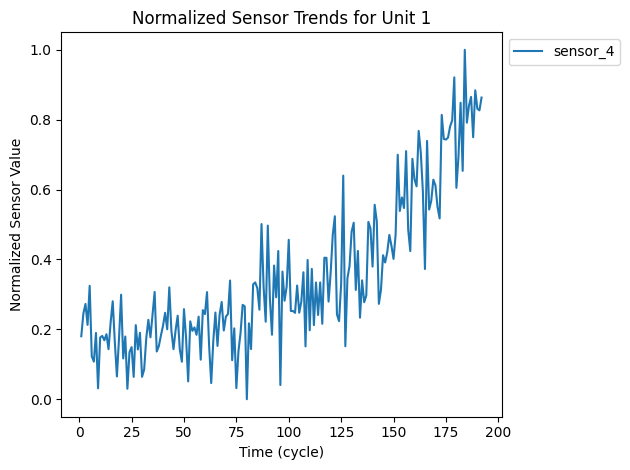

In [ ]:
# Select data for unit 1
unit1 = df[df['unit'] == 1]

scaler = MinMaxScaler()

# Normalize 'sensor_1' data (reshape to 2D array as required by the scaler)
#plot it for sensor's if variance is very low then we consider those sensors as useless
#as shown in below two plots ! in plot 1 variance is low so, we ignore sensor 1 and we consider sensor 4
sensor_1_data = unit1['sensor_1'].values.reshape(-1, 1)
sensor_4_data = unit1['sensor_4'].values.reshape(-1, 1)
normalized_1 = scaler.fit_transform(sensor_1_data)
normalized_4= scaler.fit_transform(sensor_4_data)
# Plotting
plt.plot(unit1['time'], normalized_1, label="sensor_1")
plt.xlabel("Time (cycle)")
plt.ylabel("Normalized Sensor Value")
plt.title("Normalized Sensor Trends for Unit 1")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

plt.plot(unit1['time'], normalized_4, label="sensor_4")
plt.xlabel("Time (cycle)")
plt.ylabel("Normalized Sensor Value")
plt.title("Normalized Sensor Trends for Unit 1")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
selected_sensors = ["sensor_2", "sensor_3", "sensor_4", "sensor_7", "sensor_8", "sensor_9", "sensor_11", "sensor_12", "sensor_13", "sensor_15", "sensor_17", "sensor_20", "sensor_21"]
data = df[selected_sensors]


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)
df['cluster'] = cluster_labels


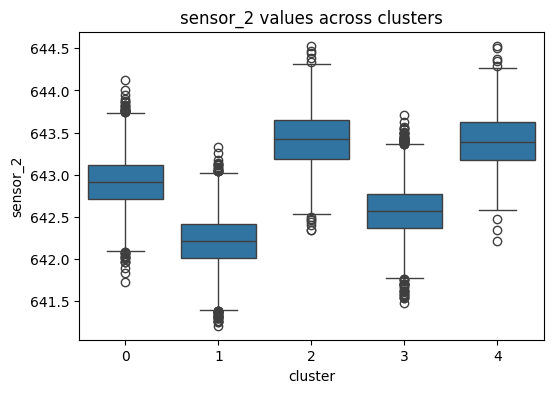

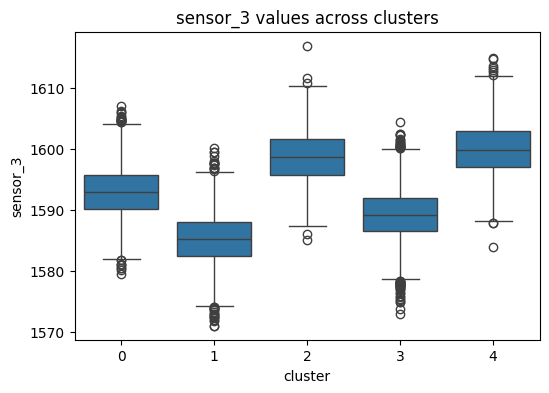

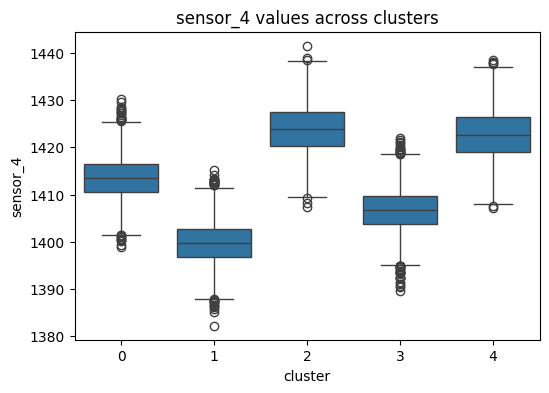

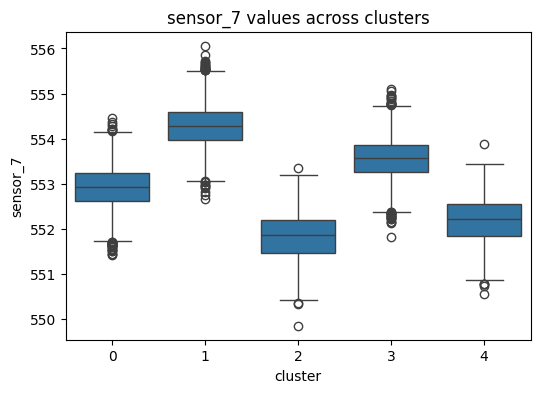

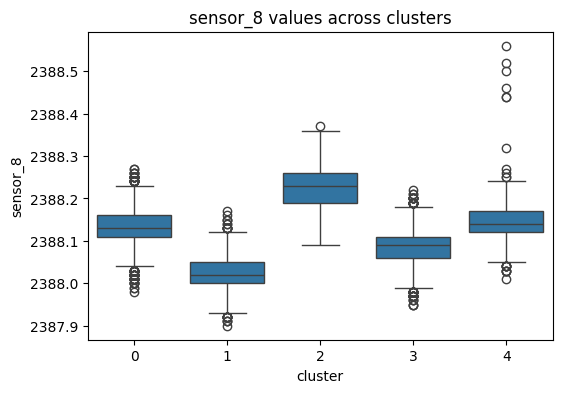

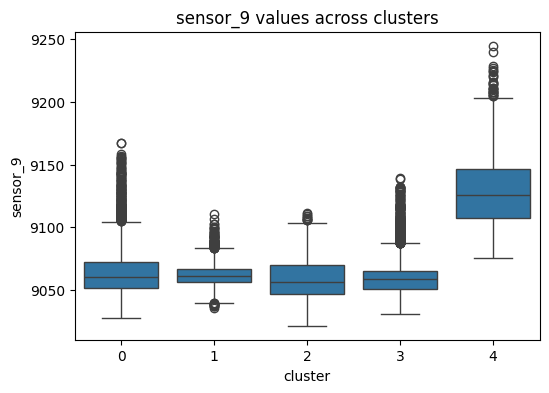

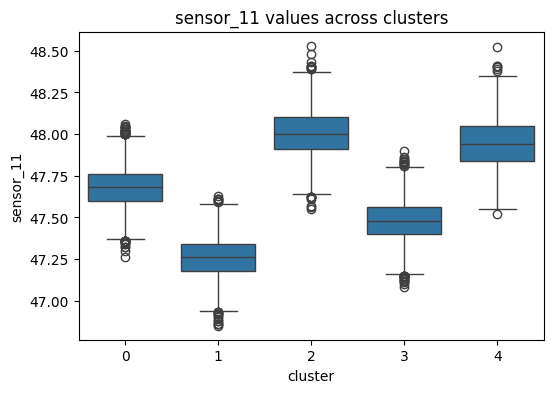

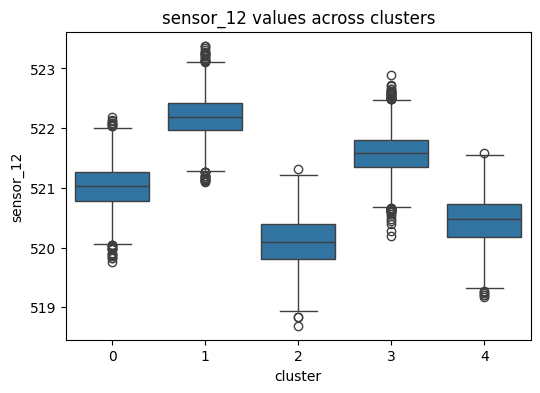

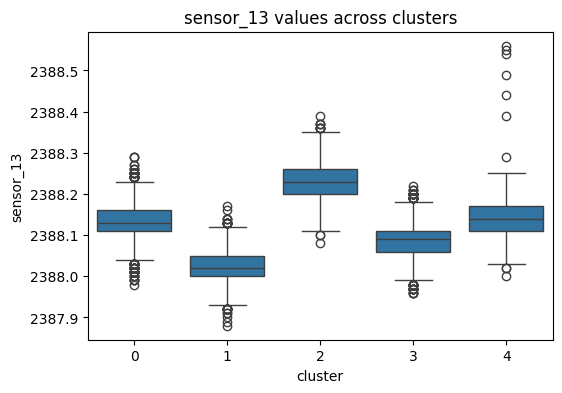

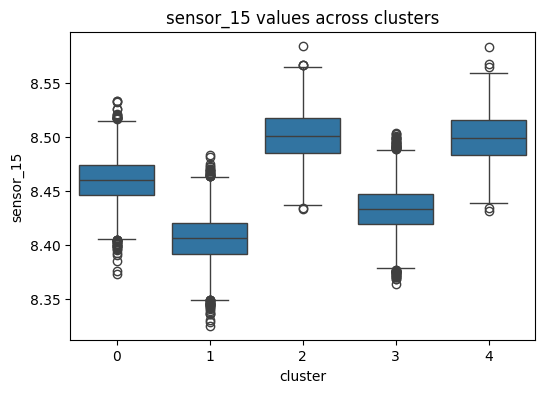

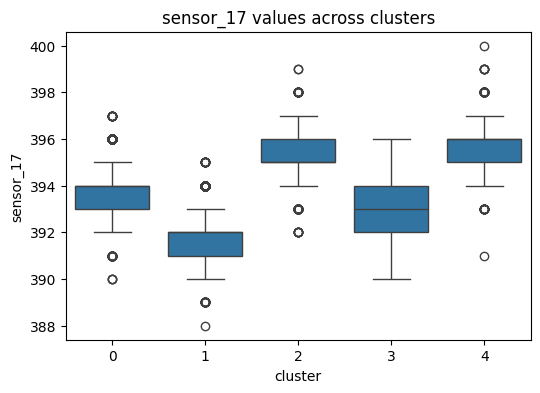

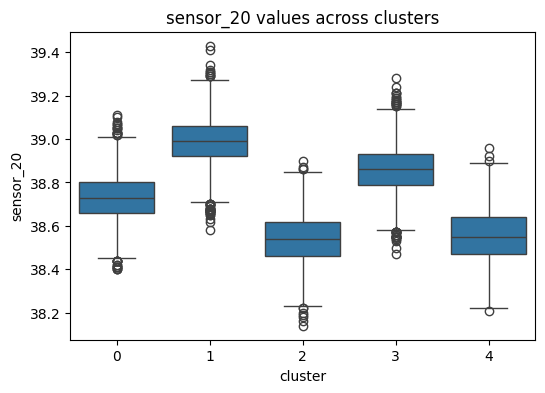

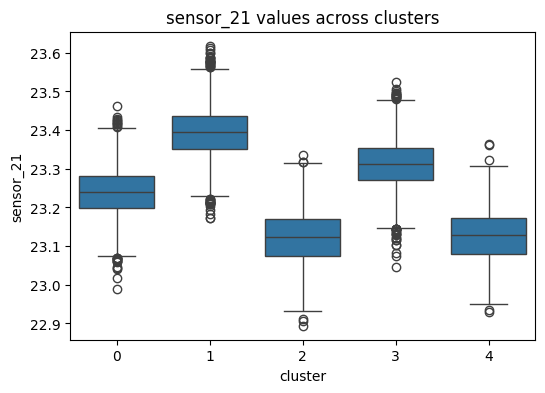

In [ ]:

for sensor in selected_sensors:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='cluster', y=sensor)
    plt.title(f"{sensor} values across clusters")
    plt.show()


In [ ]:
mapping = {
    0: 2,  # Moderately Degraded
    1: 0,  # Normal
    2: 4,  # Critical
    3: 1,  # Slightly Degraded
    4: 3   # Failure
}
df['degradation_stage'] = df['cluster'].map(mapping)



In [ ]:
cluster_summary = df.groupby('cluster')[selected_sensors].mean()
print(cluster_summary)


           sensor_2     sensor_3     sensor_4    sensor_7     sensor_8  \
cluster                                                                  
0        642.911943  1593.023371  1413.511624  552.923351  2388.132918   
1        642.216869  1585.260712  1399.798851  554.277664  2388.024210   
2        643.422945  1598.720729  1423.920213  551.829244  2388.227311   
3        642.571931  1589.219874  1406.717892  553.556829  2388.086427   
4        643.404661  1600.028493  1422.847656  552.200035  2388.142449   

            sensor_9  sensor_11   sensor_12    sensor_13  sensor_15  \
cluster                                                               
0        9064.387048  47.679515  521.024155  2388.132396   8.459793   
1        9061.845657  47.258837  522.188854  2388.022442   8.406061   
2        9058.881124  48.007274  520.092764  2388.228163   8.501333   
3        9059.801656  47.478159  521.579177  2388.086637   8.433362   
4        9129.840079  47.946573  520.453736  2388.14175

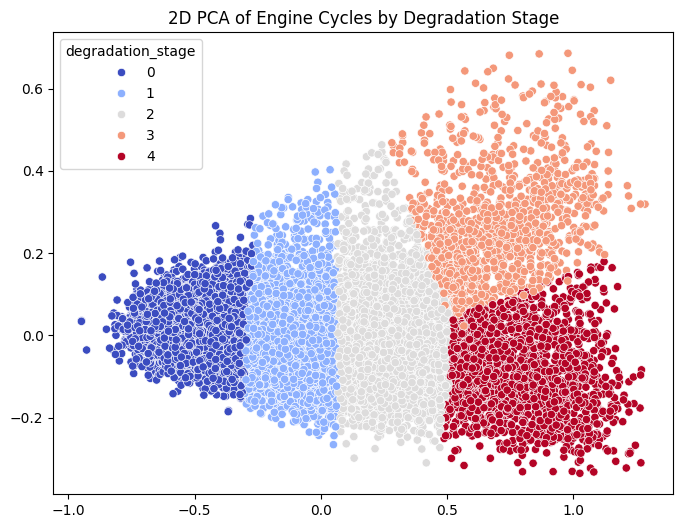

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=df['degradation_stage'], palette='coolwarm')
plt.title("2D PCA of Engine Cycles by Degradation Stage")
plt.show()


In [ ]:
mapping = {
    0: 'Moderately Degraded',  # Moderately Degraded
    1: 'Normal',  # Normal
    2: 'Failure',  # Critical
    3: 'Slightly Degraded',  # Slightly Degraded
    4: 'Critical'   # Failure
}
df['degradation_stage'] = df['cluster'].map(mapping)
df.drop(columns=['cluster'], inplace=True)
df

,unit,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,degradation_stage
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,Normal
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,Normal
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,Normal
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,Normal
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,Failure
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,Failure
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,Failure
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,Failure


Classification Report:
                     precision    recall  f1-score   support

           Critical       0.98      0.92      0.95       227
            Failure       0.97      0.94      0.95       376
Moderately Degraded       0.94      0.95      0.94      1003
             Normal       0.97      0.97      0.97      1126
  Slightly Degraded       0.94      0.95      0.95      1395

           accuracy                           0.95      4127
          macro avg       0.96      0.94      0.95      4127
       weighted avg       0.95      0.95      0.95      4127



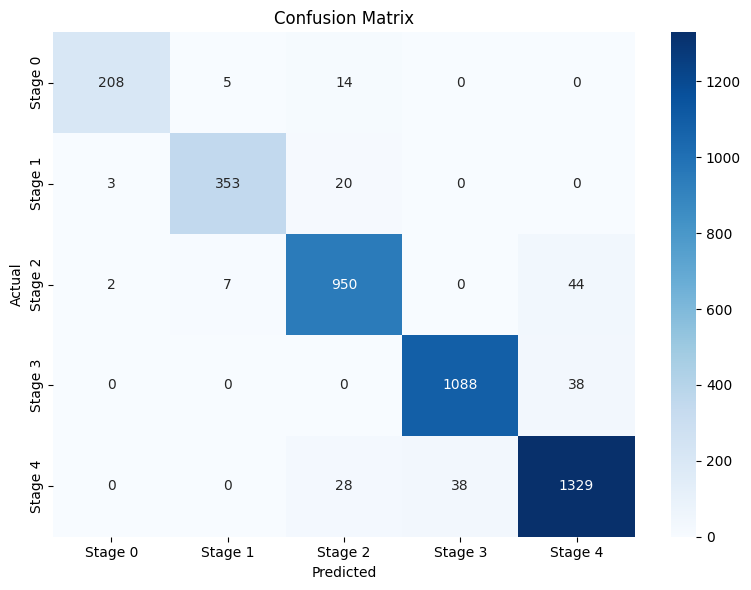

<ipython-input-41-4a9a97391c3f>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df, x="Importance", y="Sensor", palette="viridis")


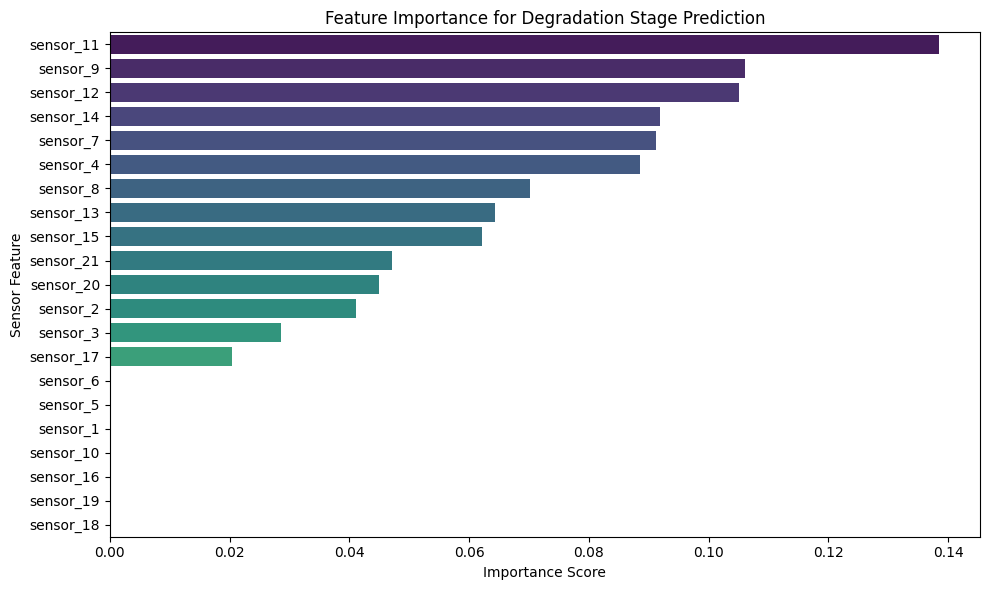

In [ ]:
# -----------------------------
# Phase 2: Classification Model
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load preprocessed and labeled data
 # This CSV must have 'stage_label' column from Phase 1

# 2. Select features and target
sensor_cols = [col for col in df.columns if 'sensor_' in col]
X = df[sensor_cols]
y = df['degradation_stage']  # Target: 0–4 stages

# 3. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train/Test split (Stratify to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Initialize and train the classifier
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)
clf.fit(X_train, y_train)

# 6. Predict on test set
y_pred = clf.predict(X_test)

# 7. Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Stage {i}' for i in range(5)],
            yticklabels=[f'Stage {i}' for i in range(5)])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

importances = clf.feature_importances_

# Create DataFrame
feature_df = pd.DataFrame({
    "Sensor": sensor_cols,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df, x="Importance", y="Sensor", palette="viridis")
plt.title("Feature Importance for Degradation Stage Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Sensor Feature")
plt.tight_layout()
plt.show()


GENERATE TIME-TO-NEXT-STAGE LABELS

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
sensor_cols = selected_sensors
# Sort data per engine and cycle
df = df.sort_values(by=['unit', 'time']).reset_index(drop=True)

# Initialize target column
df["time_to_next_stage"] = np.nan

# Compute time to next degradation stage
for unit in df["unit"].unique():
    unit_df = df[df["unit"] == unit]
    for idx in unit_df.index:
        current_stage = df.loc[idx, "degradation_stage"]
        future = unit_df.loc[idx + 1:]
        # Find first row with a higher stage
        next_rows = future[future["degradation_stage"] > current_stage]
        if not next_rows.empty:
            time_left = next_rows.iloc[0]["time"] - df.loc[idx, "time"]
            df.loc[idx, "time_to_next_stage"] = time_left

# Drop rows with no label (already in final stage)
df = df.dropna(subset=["time_to_next_stage"])
df

,unit,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,degradation_stage,time_to_next_stage
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,Normal,12.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,Normal,11.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,Normal,10.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,Normal,9.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,Normal,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20569,100,139,-0.0017,0.0002,100.0,518.67,642.86,1596.71,1408.67,14.62,...,8137.65,8.4390,0.03,394,2388,100.0,38.85,23.3012,Moderately Degraded,2.0
20570,100,140,0.0023,-0.0003,100.0,518.67,642.41,1597.20,1414.00,14.62,...,8139.44,8.4449,0.03,395,2388,100.0,38.74,23.2543,Moderately Degraded,1.0
20595,100,165,0.0010,0.0004,100.0,518.67,643.23,1599.78,1417.44,14.62,...,8146.01,8.4663,0.03,395,2388,100.0,38.41,23.0551,Failure,2.0
20596,100,166,0.0008,-0.0002,100.0,518.67,643.20,1597.24,1419.21,14.62,...,8144.95,8.4679,0.03,395,2388,100.0,38.71,23.0986,Failure,1.0



TRAIN REGRESSION MODELS

Random Forest Regressor

Random Forest Regressor - MAE: 13.885224438902743, RMSE: 21.76516713693587, R²: 0.6099062696451272


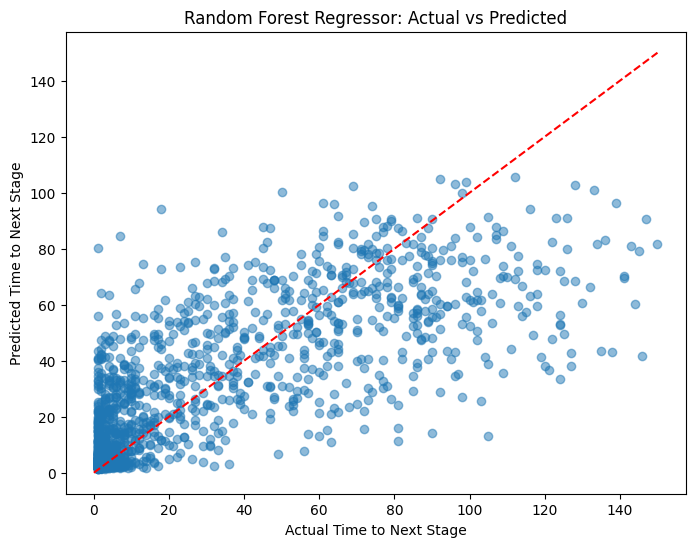

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define feature columns (sensor readings)
X = df[sensor_cols]
y = df['time_to_next_stage']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_regressor.predict(X_test)

# Evaluate the model using MAE, RMSE, and R²
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor - MAE: {mae_rf}, RMSE: {rmse_rf}, R²: {r2_rf}")

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("Actual Time to Next Stage")
plt.ylabel("Predicted Time to Next Stage")
plt.title("Random Forest Regressor: Actual vs Predicted")
plt.show()


Ridge Regression

Ridge Regression - MAE: 21.8018324679018, RMSE: 27.95072758144381, R²: 0.3566738690088892


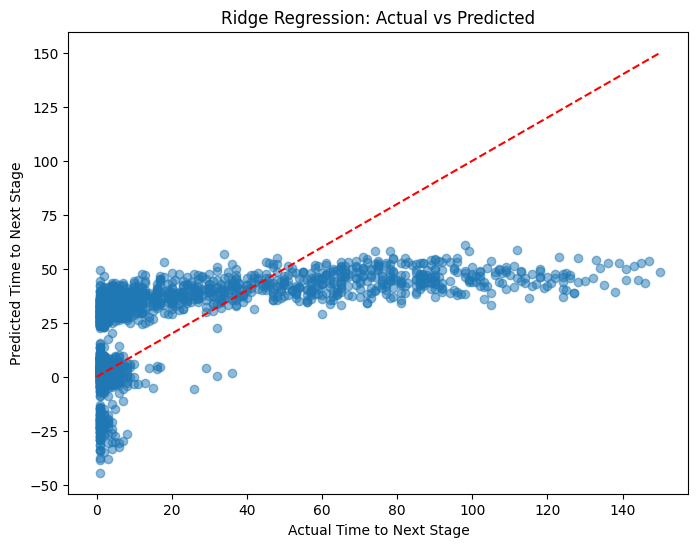

In [ ]:
from sklearn.linear_model import Ridge

# Initialize and train the Ridge Regression model
ridge_regressor = Ridge(alpha=1.0)
ridge_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_ridge = ridge_regressor.predict(X_test)

# Evaluate the model using MAE, RMSE, and R²
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression - MAE: {mae_ridge}, RMSE: {rmse_ridge}, R²: {r2_ridge}")

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("Actual Time to Next Stage")
plt.ylabel("Predicted Time to Next Stage")
plt.title("Ridge Regression: Actual vs Predicted")
plt.show()


Support Vector Regressor (SVR)

In [ ]:
from sklearn.preprocessing import StandardScaler
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.svm import SVR

# Initialize SVR model (use any kernel, e.g., 'rbf')
svr_model = SVR(kernel='rbf')

# Fit on scaled data
svr_model.fit(X_train_scaled, y_train)

# Predict on scaled test data
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluate the model using MAE, RMSE, and R²
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR_Regression - MAE : {mae_svr} , RMSE : {rmse_svr} , R2 - {r2_svr}")



SVR_Regression - MAE : 13.018768770388952 , RMSE : 21.644940045618952 , R2 - 0.6142039900239322


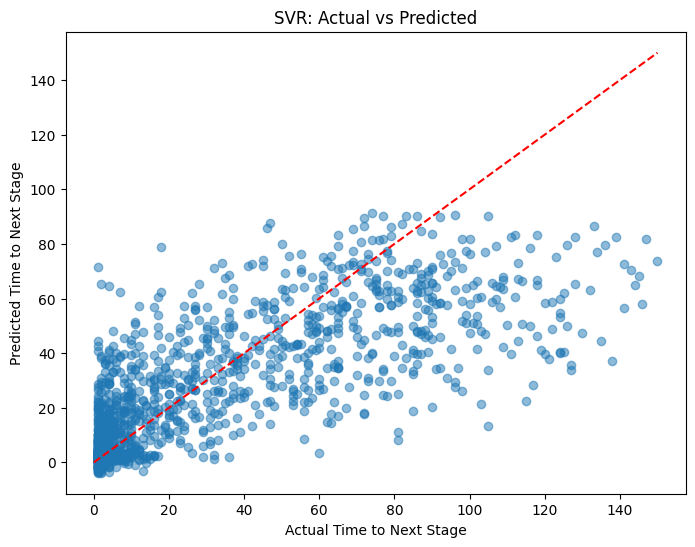

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')  # Diagonal reference line
plt.xlabel("Actual Time to Next Stage")
plt.ylabel("Predicted Time to Next Stage")
plt.title("SVR: Actual vs Predicted")
plt.show()


EVALUATION REPORT

In [ ]:
evaluation_report = pd.DataFrame({
    'Model': ['Random Forest', 'Ridge','SVR'],
    'MAE': [mae_rf, mae_ridge,mae_svr],
    'RMSE': [rmse_rf, rmse_ridge,rmse_svr],
    'R²': [r2_rf, r2_ridge,r2_svr]
})
print(evaluation_report)

           Model        MAE       RMSE        R²
0  Random Forest  13.885224  21.765167  0.609906
1          Ridge  21.801832  27.950728  0.356674
2            SVR  13.018769  21.644940  0.614204


DIAGNOSTIC PLOTS

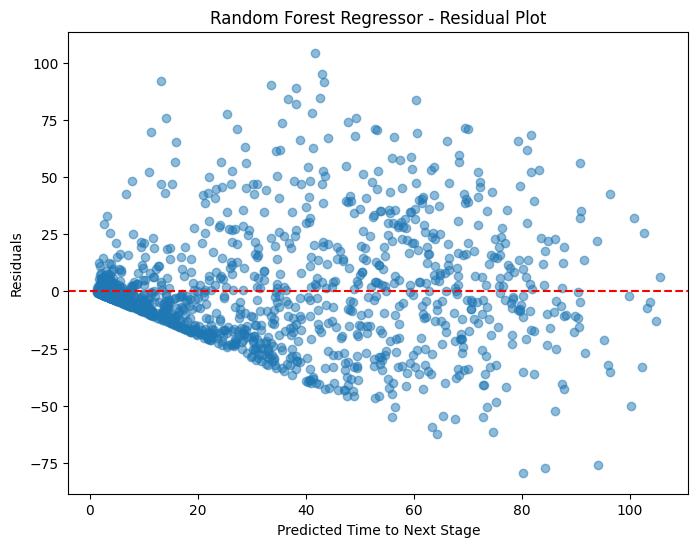

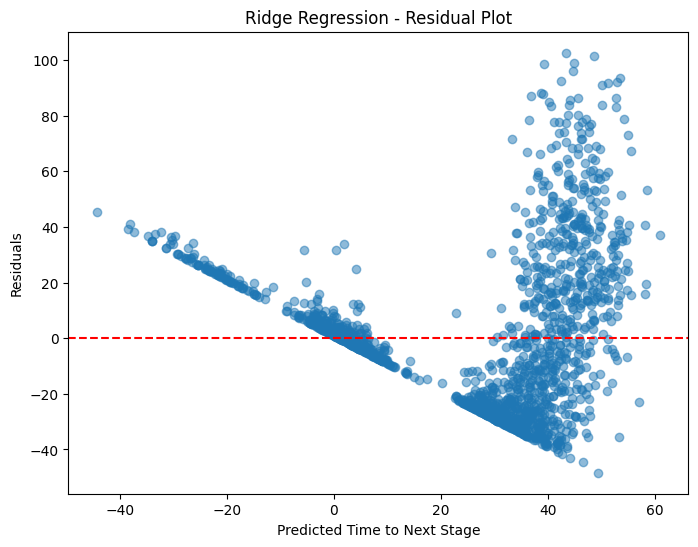

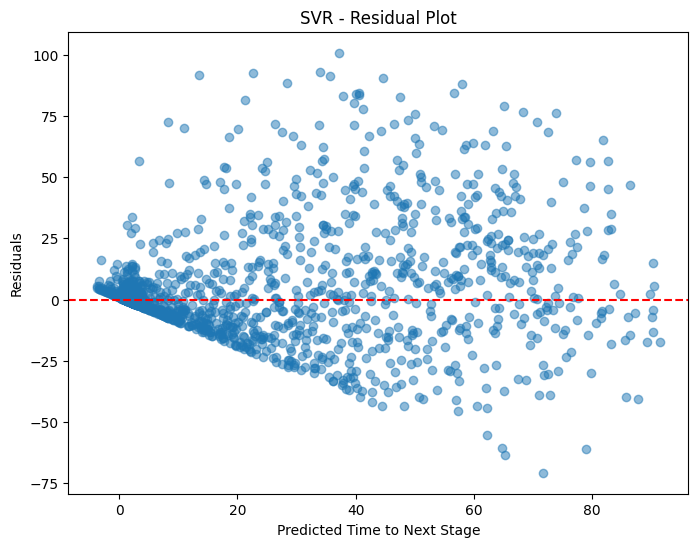

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Residual Plot for Random Forest
residual_rf = y_test - y_pred_rf
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residual_rf, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Time to Next Stage")
plt.ylabel("Residuals")
plt.title("Random Forest Regressor - Residual Plot")
plt.show()

# Residual Plot for Ridge Regression
residual_ridge = y_test - y_pred_ridge
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_ridge, residual_ridge, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Time to Next Stage")
plt.ylabel("Residuals")
plt.title("Ridge Regression - Residual Plot")
plt.show()

# Scale features for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit SVR on scaled data
svr_model = SVR()
svr_model.fit(X_train_scaled, y_train)

# Predict
y_pred_svr = svr_model.predict(X_test_scaled)

# Residual Plot for SVR
residual_svr = y_test - y_pred_svr
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_svr, residual_svr, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Time to Next Stage")
plt.ylabel("Residuals")
plt.title("SVR - Residual Plot")
plt.show()


['Critical' 'Failure' 'Moderately Degraded' 'Normal']
⚠️ Maintenance Alert! Engine: 11, Time: 96, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 15, Time: 166, Risk Score: 0.910
⚠️ Maintenance Alert! Engine: 26, Time: 72, Risk Score: 0.990
⚠️ Maintenance Alert! Engine: 43, Time: 104, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 89, Time: 40, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 82, Time: 83, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 12, Time: 61, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 16, Time: 20, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 98, Time: 1, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 18, Time: 6, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 83, Time: 118, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 95, Time: 119, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 59, Time: 113, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 61, Time: 40, Risk Score: 1.000
⚠️ Maintenance Alert! Engine: 7, Time: 52, Risk Score: 1.000
⚠️ Maintenance

<ipython-input-72-42eefdbef25a>:76: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


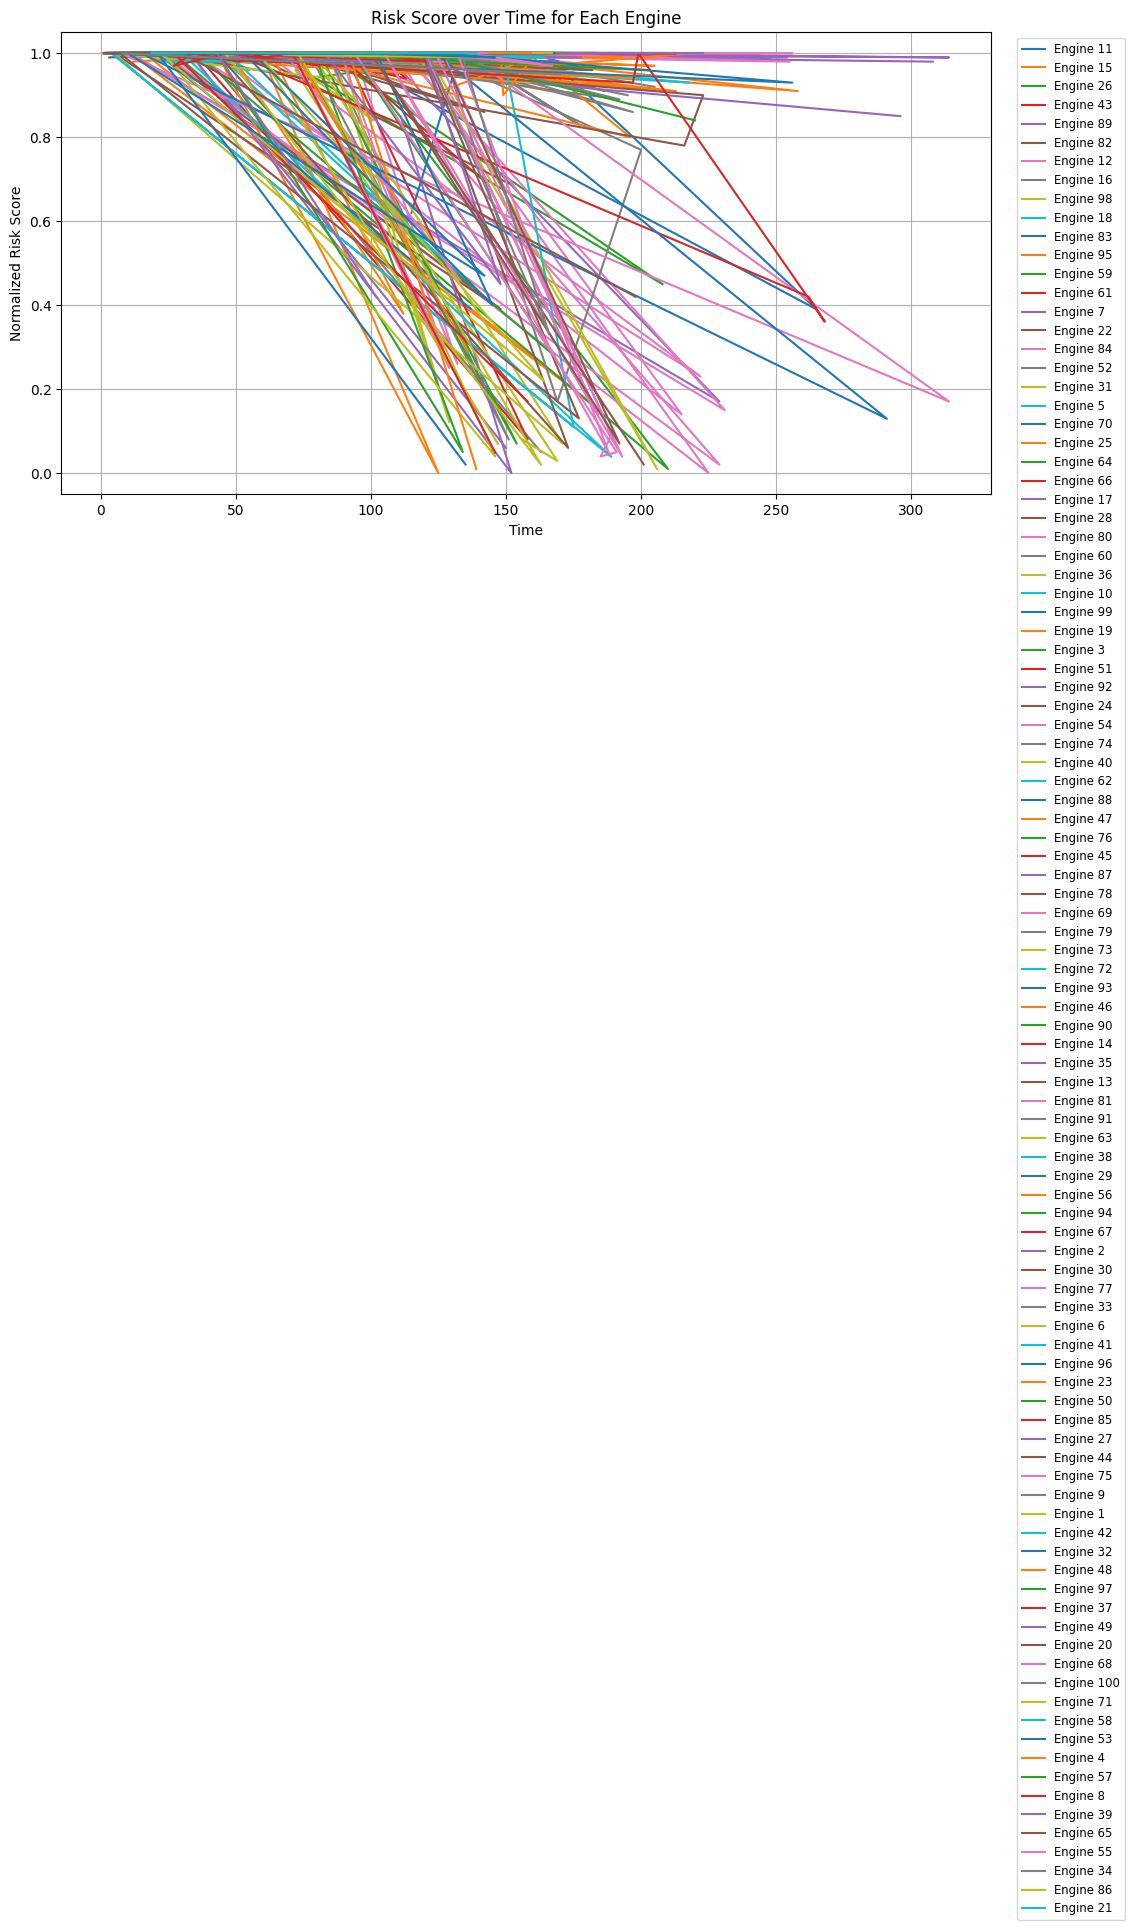

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

# Assume these are trained models
# clf -> Classifier (e.g., LogisticRegression, XGBoost, etc.)
# svr_regressor -> Regression model (e.g., SVR)
# X_test -> Test features
# df_test -> Original test dataframe containing 'unit', 'time', and 'degradation_stage' columns

# --- Predict failure probability (Stage 4 = "Failure") ---

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)


sensor_cols = ["sensor_2", "sensor_3", "sensor_4", "sensor_7", "sensor_8", "sensor_9", "sensor_11", "sensor_12", "sensor_13", "sensor_15", "sensor_17", "sensor_20", "sensor_21"]

X_train = df_train[sensor_cols].values
X_test = df_test[sensor_cols].values
X_test_df = pd.DataFrame(X_test, columns=sensor_cols)
X_train_df = pd.DataFrame(X_train, columns=sensor_cols)

y_train_class = df_train["degradation_stage"]
df_last = df_test.groupby("unit").last().reset_index()
# Confirm classifier is trained
print(clf.classes_)  # Check if "Failure" is present

# Make sure column match
assert list(X_test_df.columns) == list(X_train_df.columns)

#retraining
clf.fit(X_train_df, y_train_class)

# Predict failure probabilities
failure_index = list(clf.classes_).index("Failure")  # Only if "Failure" is a class
failure_probabilities = clf.predict_proba(X_test_df)[:, failure_index]

# --- Predict remaining useful life (time left to failure) ---
time_left = svr_regressor.predict(X_test)

# --- Compute Raw Risk Score ---
raw_risk_score = failure_probabilities * time_left

# --- Normalization 1: Min-Max ---
min_score = raw_risk_score.min()
max_score = raw_risk_score.max()
normalized_risk_score = (raw_risk_score - min_score) / (max_score - min_score + 1e-6)

# --- Normalization 2: Urgency-Based Inversion ---
urgency_risk_score = failure_probabilities / (time_left + 1e-6)


   # --- Set fixed threshold for issuing alerts ---
threshold = 0.7

# --- Issue maintenance alerts based on normalized risk score ---
for i in range(len(normalized_risk_score)):
    if normalized_risk_score[i] > threshold:
        unit = df_test.iloc[i]['unit'] if 'unit' in df_test.columns else f"Sample {i}"
        time = df_test.iloc[i]['time'] if 'time' in df_test.columns else "Unknown Time"
        print(f"⚠️ Maintenance Alert! Engine: {unit}, Time: {time}, Risk Score: {normalized_risk_score[i]:.3f}")

# --- Plot Risk Score Over Time for Each Engine ---
plt.figure(figsize=(12, 6))
for unit in df_test['unit'].unique():
    unit_mask = df_test['unit'] == unit
    plt.plot(df_test.loc[unit_mask, "time"], normalized_risk_score[unit_mask], label=f"Engine {unit}")

plt.xlabel("Time")
plt.ylabel("Normalized Risk Score")
plt.title("Risk Score over Time for Each Engine")
plt.grid(True)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1), ncol=1, fontsize="small")
plt.tight_layout()
plt.show()
